# Stitched 1D Time-Domain Inversion

Here we use the module *SimPEG.electromangetics.time_domain_1d* to perform
a stitched 1D inversion on a 3D TDEM (time-domain electromagnetic) dataset. That is, we recover a local 1D
conductivity model for each sounding. In this tutorial, we focus on the following:

    - Defining receivers, sources and the survey for the stitched 1D case
    - Implementing a regularization that connects nearby 1D vertical conductivity profiles
    - Recovering a stitched model composed of a 1D vertical conductivity profile at each sounding location

For each sounding, the survey geometry consisted of horizontal loop source
with a radius of 10 m, located 30 m above the Earth's surface. The receiver
measured the vertical component of db/dt at the loop's centre.


## Import moduls

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import os
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
from discretize import TensorMesh, SimplexMesh
from pymatsolver import PardisoSolver



from SimPEG.utils import mkvc
from SimPEG import (
    maps, data, data_misfit, inverse_problem, regularization, optimization,
    directives, inversion, utils
    )

import SimPEG.electromagnetics.time_domain as tdem
from SimPEG.electromagnetics.utils.em1d_utils import (
    get_vertical_discretization, set_mesh_1d, Stitched1DModel
)


In [2]:

save_file = False

plt.rcParams.update({'font.size': 16, 'lines.linewidth': 2, 'lines.markersize':8})

## Download Test Data File

Here we provide the file path to the data we plan on inverting. The path to the data file is stored as a tar-file on our google cloud bucket: "https://storage.googleapis.com/simpeg/doc-assets/em1dtm_stitched.tar.gz"
 storage bucket where we have the data

In [5]:
file_name="em1dtm_stitched_data.csv"
dir_path="./outputs"

if not(os.path.isfile(os.path.join(dir_path, file_name))):
    print('data does not exist, downloading ....' )

    # storage bucket where we have the data
    data_source = "https://storage.googleapis.com/simpeg/doc-assets/em1dtm_stitched_fwd.tar.gz"
    
    # download the data
    downloaded_data = utils.download(data_source, overwrite=True)
    
    # unzip the tarfile
    tar = tarfile.open(downloaded_data, "r")
    tar.extractall()
    tar.close()
    
    # path to the directory containing our data
    dir_path = downloaded_data.split(".")[0] + os.path.sep
else:
    print('using file from disk:')

# files to work with
data_filename = os.path.join(dir_path, file_name)
time_filename = os.path.join(dir_path, "times.txt")

print(data_filename)

using file from disk:
./outputs/em1dtm_stitched_data.csv


## Load Data and Plot

Text(0.5, 1.0, 'Observed data')

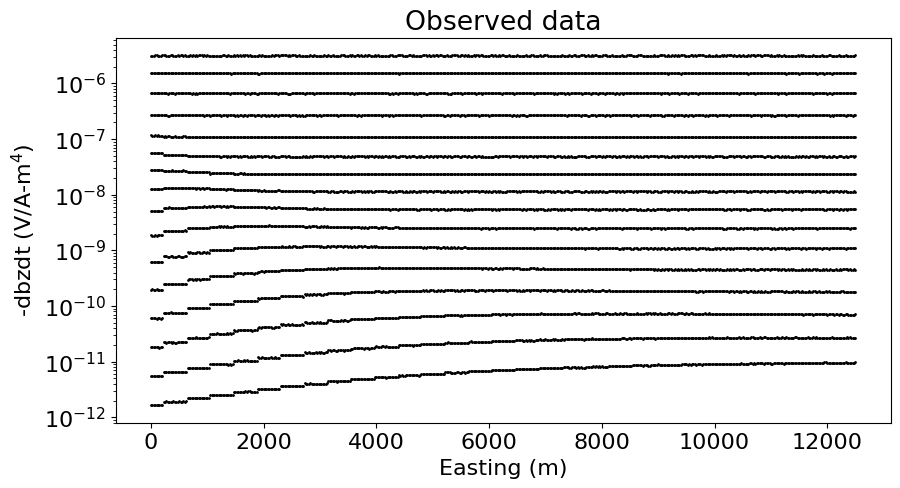

In [6]:
# Load field data
df = pd.read_csv(data_filename)

source_locations = df[['X', 'Y', 'Z']].values
n_sounding = np.shape(source_locations)[0]

data_header = np.array(list(key for key in df.columns[6:]))
tdem_data = df[data_header].values


times = np.loadtxt(time_filename)

n_time = len(times)

group_line = df.groupby('LINENO')

uniq_line = list(group_line.groups.keys())
data_tmp = group_line.get_group(uniq_line[0])[data_header].values
fig, ax = plt.subplots(1,1,figsize=(10, 5))
x = group_line.get_group(uniq_line[0])['X'].values
_ = ax.semilogy(x, -data_tmp, 'k.', ms=2, lw=1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("-dbzdt (V/A-m$^4$)")
ax.set_title("Observed data")

# Create Survey
Here we define the waveform, receivers, sources and the survey needed to invert the data. The survey consisted of a line of equally spaced 1D soundings along the Easting direction. For each sounding, the survey geometry consisted of a horizontal cirular loop with a radius of 6 m, located 25 m above the Earth's surface. The receiver measured the vertical component of dbdt at the loop's centre due in response to a unit step-off waveform.



In [7]:

current_amplitude = 1.
source_radius = 10.

receiver_locations = np.c_[source_locations[:, 0], source_locations[:, 1:]]
receiver_orientation = "z"

waveform = tdem.sources.StepOffWaveform()

source_list = []

for ii in range(0, n_sounding):

    source_location = mkvc(source_locations[ii, :])
    receiver_location = mkvc(receiver_locations[ii, :])

    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times, orientation=receiver_orientation
        )
    ]

    # Sources
    source_list.append(
        tdem.sources.CircularLoop(
            receiver_list=receiver_list, location=source_location, waveform=waveform,
            radius=source_radius, current=current_amplitude, i_sounding=ii
        )
    )

# Survey
survey = tdem.Survey(source_list)
sounding_types = np.ones(n_sounding, dtype=int)
survey._sounding_types = sounding_types

## Assign Uncertainties and Define Data

Here is where we define the data that are being inverted and their uncertainties.A data object is used to define the survey, the observation values and the uncertainties.

In [8]:
# Define uncertainties
dobs = tdem_data.flatten()
uncertainties = 0.03*np.abs(dobs)*np.ones(np.shape(dobs))

# Define the data object
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)


## Define Layer Thicknesses Used for All Soundings
Although separate 1D models are recovered for each sounding, the number of layers and the thicknesses is the same for each sounding. For a background conductivity and a set of frequencies, we can determine the the optimum layer thicknesses for a set number of layers. Note that when defining the thicknesses, it is the number of layers minus one.

In [9]:
n_layer = 30
thicknesses = get_vertical_discretization(n_layer-1, 3, 1.07)

>> Depth from the surface to the base of the bottom layer is 262.0m


##  Define a Mapping and a Starting/Reference Model

When defining a starting or reference model, it is important to realize that the total number of conductivity required is the number of layers times the number of soundings. To keep the tutorial simple, we will invert for the log-conductivity. Where *mi* is a 1D array  representing the 1D conductivity model for sounding *i*, the 1D array containing all 1D conductivity models is organized as [m1,m2,m3,...].

In [10]:
n_param = n_layer*n_sounding  # Number of model parameters

# Define the conductivities for all layers for all soundings into a 1D array.
conductivity = np.ones(n_param) * 0.1

# Define the mapping between the model and the conductivitys
mapping = maps.ExpMap(nP=n_param)

# Define the starting model
starting_model = np.log(conductivity)

## Define the Forward Problem Using the Simulation Class

In [11]:
simulation = tdem.Simulation1DLayeredStitched(
    survey=survey, thicknesses=thicknesses, sigmaMap=mapping,
    solver=PardisoSolver,
    parallel=True, n_cpu=4, 
    n_layer=n_layer
)

## Define Inverse Problem

The inverse problem is defined by 3 things:
1) Data Misfit: a measure of how well our recovered model explains the field data
2) Regularization: constraints placed on the recovered model and a priori information
3) Optimization: the numerical approach used to solve the inverse problem

In [12]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1./uncertainties

In [13]:
# Define the regularization (model objective function). Here we use a laterally
# constrained regularization. This regularization connects the 1D models of
# nearby soundings and ensure lateral changes in electrical conductivity are
# sufficiently smooth.
hz = np.r_[thicknesses, thicknesses[-1]]  # We need to include a thickness for bottom layer
tri = Delaunay(source_locations[:,:2])

mesh_radial = SimplexMesh(tri.points, tri.simplices)
mesh_vertical = set_mesh_1d(hz)
mesh_reg = [mesh_radial, mesh_vertical]
n_param = int(mesh_radial.n_nodes * mesh_vertical.nC)
reg_map = maps.IdentityMap(nP=n_param)    # Mapping between the model and regularization
reg = regularization.LaterallyConstrained(
    mesh_reg, mapping=reg_map,
    alpha_s = 1e-10,
    alpha_r = 1.,
    alpha_z = 1.,
)


In [14]:
# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter = 40, maxIterCG=20)

In [15]:
# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This includes the cooling schedule for the trade-off parameter (beta), stopping criteria for the inversion and saving inversion results at each iteration.

In [16]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)

# Defining how to cool the trade-off parameter, beta, through out the inversion
# coolingFactor=2, coolingRate=1 indicate the beta value is decreased with a factor of 2
# for every iteration.

beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

target =directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [
    starting_beta,
    beta_schedule,
    target
]


## Running the Inversion

To define the inversion object, we need to define the inversion problem and the set of directives. We can then run the inversion.


In [17]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

In [18]:
# Run the inversion
start = time.time()
recovered_model = inv.run(starting_model)
end = time.time()
print("\nTime used for inversion:{0:5.2f} min".format( (end - start)/60))

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/usr/local/lib/python3.8/dist-packages/discretize/base/base_tensor_mesh.py:1017: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh._cellGradStencil has been deprecated, please use TensorMesh.stencil_cell_gradient. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.87e+02  1.90e+07  0.00e+00  1.90e+07    6.22e+05      0              
   1  1.94e+02  3.00e+06  3.76e+02  3.08e+06    1.14e+05      0              
   2  9.68e+01  3.18e+05  5.69e+02  3.73e+05    1.87e+04      0   Skip BFGS  
   3  4.84e+01  4.34e+04  8.07e+02  8.25e+04    4.75e+03      0   Skip BFGS  
   4  2.42e+01  1.56e+04  1.02e+03  4.01e+04    1.22e+03      0   Skip BFGS  
   5  1.21e+01  7.95e+03  1.23e+03  2.29e+04    7.88e+02      0   Skip BFGS  
   6  6.05e+00  4.38e+03  1.44e+03  1.31e+04    4.79e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.8954e+06
1 : |xc-x_last| = 4.5557e+00 <= tolX*(1+|x0|) = 2.8329e+01
0 : |p

## Plot the results

In [ ]:
# Generate a Stitched1DModel object for plotting
line = df['LINENO'].values
topography = df[['X', 'Y', 'ELEVATION']].values
time_stamp = df['SOUNDINGNUMBER'].values

model_plot = Stitched1DModel(
    hz=hz,
    line=line,
    time_stamp=time_stamp,
    topography=topography,
    physical_property=1./np.exp(recovered_model),
    n_layer=n_layer
)

fig, ax = plt.subplots(1,1, figsize=(10, 8))
_, ax, cb = model_plot.plot_section(i_line=0, aspect=1, dx=20, cmap='turbo', clim=(8, 100), ax=ax)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_aspect(10)

In [ ]:
# Predict data
dpred = simulation.dpred(recovered_model)
dpred_plot = np.reshape(dpred, (n_sounding, len(times)))

In [ ]:


fig= plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])

ax.semilogy(receiver_locations[:, 0], np.abs(tdem_data), 'b.', label='obs')
ax.semilogy(receiver_locations[:, 0], np.abs(dpred_plot), 'k-', label='fwd')

ax.set_xlabel("Sounding location (m)")
ax.set_ylabel("|dBdt| (T/s)")
#ax.set_title("Line nubmer {:.0f}".format(i_line))